In [2]:
import sys
import os
from re import split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from dask.distributed import Client, progress
from dask.distributed import Client, LocalCluster
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
# import tensorflow_docs as tfdocs
# import tensorflow_docs.plots
# import tensorflow_docs.modeling
from tensorflow.keras import regularizers
import pandas as pd
import numpy as np
from scipy.special import gamma
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
# from sklearn.metrics import confusion_matrix
import xarray as xr
from matplotlib.colors import ListedColormap
sys.path.insert(1, f"{os.path.abspath(os.path.join(os.path.abspath(''), '../'))}")
from src.utils import get_pars_from_ini, make_dir

location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(file_name='loc')[location]['path_data']

In [3]:
device_name = tf.test.gpu_device_name()
print(device_name)
if device_name != '/device:GPU:0':
  # raise SystemError('GPU device not found')
  print('Found GPU at: {}'.format(device_name))
else:
  print(device_name)


Found GPU at: 


2023-08-21 09:00:11.107851: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-21 09:00:11.113672: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-08-21 09:00:11.113721: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-21 09:00:11.113757: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (keeling-j09): /proc/driver/nvidia/version does not exist


In [4]:
cluster = LocalCluster()  
cluster

LocalCluster(40869865, 'tcp://127.0.0.1:36693', workers=8, threads=48, memory=48.00 GiB)

In [5]:
def norm_gamma(d, nw, mu, dm):
    f_mu = (6 * (4 + mu) ** (mu + 4)) / (4 ** 4 * gamma(mu + 4) )
    slope = (4 + mu) / dm
    return nw * f_mu * (d / dm) ** mu * np.exp(-slope * d)

def plot_history(history):
    fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 5))
    hist['epoch'] = history.epoch


    ax.set_xlabel('$Epoch$')
    ax.set_ylabel('$Loss$')
    ax.set_title('$Mean \ Absolute \  Error$')
    ax.plot(hist['epoch'], hist['mae'], label='$Training$')
    try:
        ax.plot(hist['epoch'], hist['val_mae'], label='$Validation$')
    except KeyError:
        pass
    # plt.ylim([0,5])
    ax.legend()

    ax1.set_xlabel('$Epoch$')
    ax1.set_ylabel("$Loss$")
    ax1.set_title('$Mean \ Square \ Error$')
    ax1.plot(hist['epoch'], hist['mse'],
             label='$Training$')
    try:
        ax1.plot(hist['epoch'], hist['val_mse'],
                  label='$Validation$')
    except KeyError:
        pass
    # plt.ylim([0,3])
    ax1.legend()
    plt.savefig("../results/loss.jpeg",  bbox_inches="tight")
    plt.show()
    

def metrics_pd(x, xpred):
    xpred = xpred.astype(float)
    x = x.astype(float)
    x = x[(~np.isnan(xpred)) & (~np.isinf(xpred))]
    xpred = xpred[(~np.isnan(xpred)) & (~np.isinf(xpred))]
    rmse = np.sqrt(np.sum((xpred - x) ** 2 / len(x)))
    mae = np.sum(np.abs(xpred - x)) / len(x)
    corr = np.corrcoef(x, xpred)**2.
    return rmse, mae, corr[0, 1]

def rain_retrieval(nw, mu, dm, d, d_d, vel_m='lerm'):
    lerm_vel: Callable[[float], float] = lambda diam: 9.25 * (1 - np.exp(-0.068 * diam ** 2 - 0.488 * diam))  # d in mm
    ulbr_vel: Callable[[float], float] = lambda diam: 3.78 * diam ** 0.67  # with d in mm
    if vel_m == 'lemr':
        vel = lerm_vel(d)
    else:
        vel = ulbr_vel(d)
    f_mu = (6 * (mu + 4) ** (mu + 4)) / (4 ** 4 * gamma(mu + 4))
    r = 6 * np.pi * 1e-4 * (nw * f_mu * (d / dm) ** mu * np.exp(-(4 + mu) * (d / dm)) * vel * d ** 3 * d_d)
    return r.sum('diameter')

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [6]:
store = f"{path_data}/cloud_probes/zarr/dm_retrieved_Lear_corr.zarr"
store1 = f"{path_data}/cloud_probes/zarr/combined_psd_Lear_600_1000_5_bins.zarr"
store2 = f"{path_data}/cloud_probes/zarr/combined_psd_P3B_600_1000_5_bins.zarr"
store3 = f"{path_data}/cloud_probes/zarr/dm_retrieved_P3B_corr.zarr"

In [7]:
dm_lear = xr.open_zarr(store)
dm_p3b = xr.open_zarr(store3)
ds_lear = xr.open_zarr(store1)
ds_lear['altitude'] = ds_lear['altitude'] * 0.3046
ds_lear = ds_lear.drop_sel(time='2019-09-09 00:54:08')
ds_p3b = xr.open_zarr(store2)

/data/keeling/a/alfonso8/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/xarray/backends/plugins.py:64: RuntimeWarning: Engine 'gini' loading failed:
cannot import name 'Self' from 'typing_extensions' (/data/keeling/a/alfonso8/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/typing_extensions.py)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [8]:
ds_new_lear = xr.merge([dm_lear, ds_lear], compat='override')
ds_new_p3b = xr.merge([dm_p3b, ds_p3b], compat='override')

In [9]:
new_cols = ['dbz_t_ka', 'dbz_t_ku', 'Att_ku', "Att_ka", 'nt', 'lwc_cum', 'mu', 'new_mu', 'mu3', 'mu_bf','sigma', 'sigmap', 'dm', 
            'log10_nw', 'r', 'dfr', 'temp', 'vert_vel', 'altitude','z_ku_mu1', 'z_ku_mu2', 'z_ku_mu3', 'z_ku_mu_bf',
            'z_ka_mu1', 'z_ka_mu2', 'z_ka_mu3', 'z_ka_mu_bf', 'lon', 'lat', 'r', 'r_dm_gm_mu_3', 'r_gpm_operational', 'r_true_nw_mu_dm', 
           'dm_rt_dfr_gm_mu_3', 'dm_rt_dfr_nd_mu_3', 'log10nw_dm_gm_mu_3']

In [12]:
dm_l = ds_new_lear[new_cols]
dm_p = ds_new_p3b[new_cols]
ds = xr.concat([dm_l, dm_p], dim='time')
ds = ds.where(ds.lwc_cum > 0.01, drop=True)

In [16]:
df = ds.to_dataframe()
df = df.reset_index()
df.shape

(8710, 36)

# K-means clustering

In [17]:
df['logr'] = np.log10(df.r)
df['lognt'] = np.log10(df.nt)
df['loglwc'] = np.log10(df.lwc_cum)

cols = ['sigma_T', 'dm_T', 'log10_nw_T', 'logr_T', 'lognt_T', "loglwc_T"]
scaler = StandardScaler()
df[cols]= scaler.fit_transform(df[['sigma', 'dm', 'log10_nw', 'logr', 'lognt', 'loglwc']])

n_c = 6
X = df[['sigma_T', 'dm_T', 'log10_nw_T', 'logr_T', 'lognt_T', "loglwc_T"]]
kmeans = KMeans(n_clusters=n_c, random_state=10)
kmeans.fit(X)

df['kmeans_6'] = kmeans.labels_

/data/keeling/a/alfonso8/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [18]:
df['dfr'] = df['dbz_t_ku'] - df['dbz_t_ka']
df['dm_class'] = (df.dm > 1.0).astype(int)
df.shape

(8710, 47)

In [19]:
sns.set(rc={"figure.dpi":120, 'savefig.dpi':120})

In [20]:
# construct cmap
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
my_cmap6 = ListedColormap(sns.color_palette(flatui).as_hex())

colors6 = my_cmap6(np.linspace(0,1,n_c))

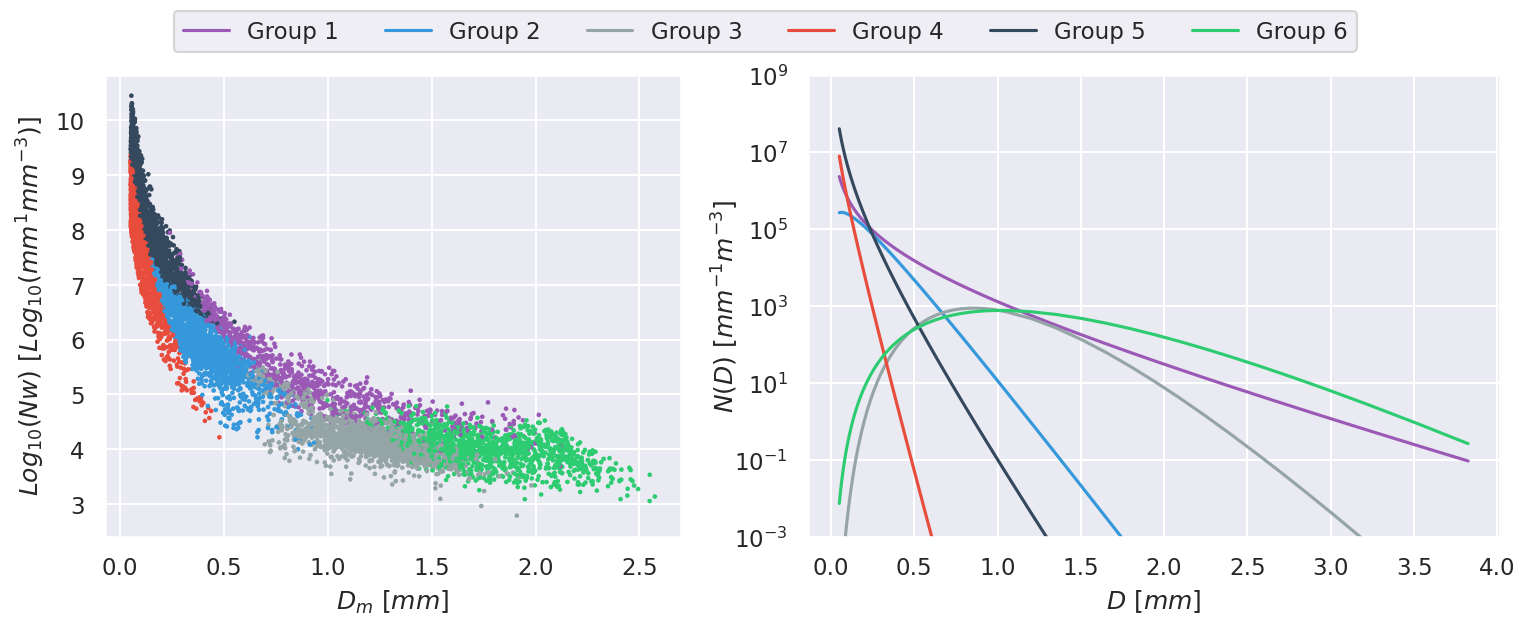

In [21]:
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12,4), dpi=150,  gridspec_kw={'width_ratios': [1, 1.2]})
sc = ax.scatter(df['dm'], df['log10_nw'], c=df['kmeans_6'], s=1.5, cmap=my_cmap6)
ax.set_xlabel("$D_m \ [mm]$")
ax.set_ylabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
# fig.colorbar(sc, ax=ax, label="Group number")

ax1.set_yscale('log')
ax1.set_ylim(1e-3, 1e9)
d = ds_lear.diameter/1000
ax1.grid('both')
n = df['kmeans_6'].max() + 1
ax1.set_ylabel("$N(D) \  [mm^{-1}m^{-3}]$", labelpad=-3)
ax1.set_xlabel("$D\ [mm]$")
# colors = pl.cm.jet(np.linspace(0,1,n))
for i in range(0,n):
    df_sub = df[df['kmeans_6'] == i]
    mu = df_sub['mu'].quantile(.50)
    dm = df_sub['dm'].quantile(.50)
    nw = (10 ** (df_sub['log10_nw'])).quantile(0.5)
    gm = norm_gamma(d, nw=nw, mu=mu, dm=dm)
    ax1.plot(ds_lear.diameter/1000, gm, c=colors6[i], label=f"Group {i + 1}")
# ax1.legend()
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='upper center', ncol=6)
plt.savefig("../results/clusters.jpeg",  bbox_inches = "tight")

# Train neural Network

In [22]:
X = df[['dbz_t_ku', 'dfr']]
Y = df[['log10_nw', 'dm', 'new_mu']]

In [23]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_x.fit_transform(X)
Y_scaled = scaler_y.fit_transform(Y)

In [24]:
Y_scaled = np.append(Y_scaled, df.dm_class.values[:, np.newaxis], axis=1)
Y_scaled = np.append(Y_scaled, df.kmeans_6.values[:, np.newaxis], axis=1)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y_scaled, test_size=0.25, random_state=20, stratify=df.kmeans_6)

In [26]:
def build_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(8, activation="relu",
                                    input_shape=[X_train.shape[1]]))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(3))
    # optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)
    # optimizer = tf.keras.optimizers.RMSprop(0.001)
    # optimizer = tf.keras.optimizers.Adadelta(0.1)
    # optimizer = tf.keras.optimizers.AdamW(0.001)
    # optimizer = tf.keras.optimizers.SGD(0.001)
    model.compile(loss="mse",
              optimizer=optimizer,
              metrics=['mae', 'mse'])
    return model

In [27]:
model = build_model()

In [28]:
EPOCHS = 1000

In [29]:
history = model.fit(X_train, y_train[:, :3],
                    validation_data=(X_test, y_test[:,:3]),
                    epochs=EPOCHS,
                    batch_size=32, verbose=0,
                    callbacks=[PrintDot(), early_stop])

2023-08-21 09:04:35.808237: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)



....................................................................................................
....................................................................................................
.............................................................................

In [30]:
hist = pd.DataFrame(history.history)

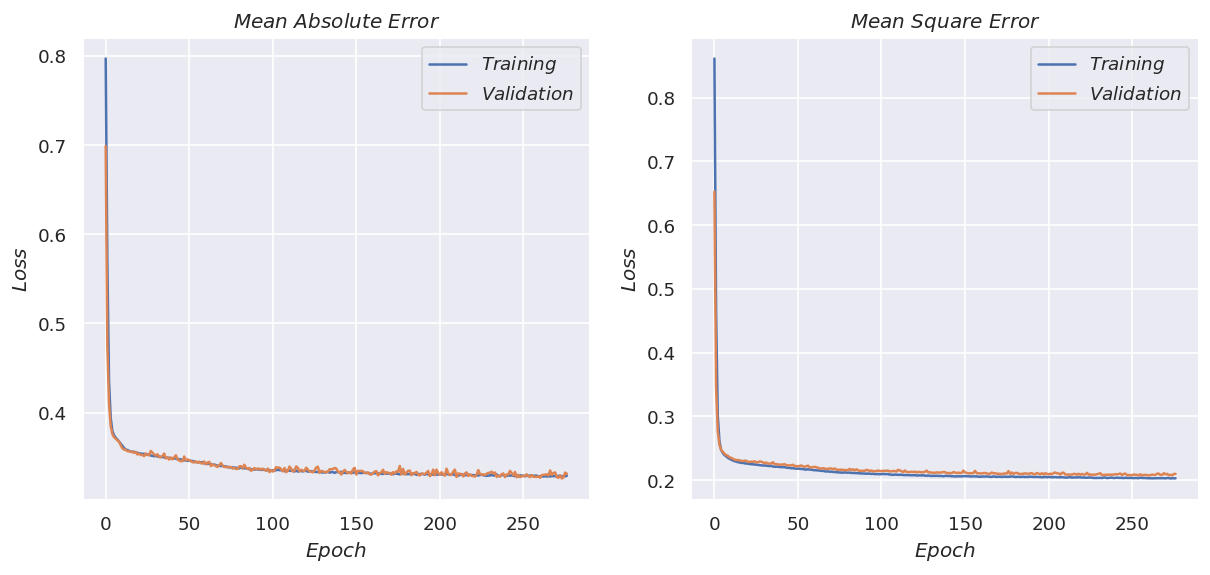

In [31]:
plot_history(history)

In [32]:
yhat = model.predict(X_test)
yhat = scaler_y.inverse_transform(yhat)
y_test_unscaled = scaler_y.inverse_transform(y_test[:, :3])

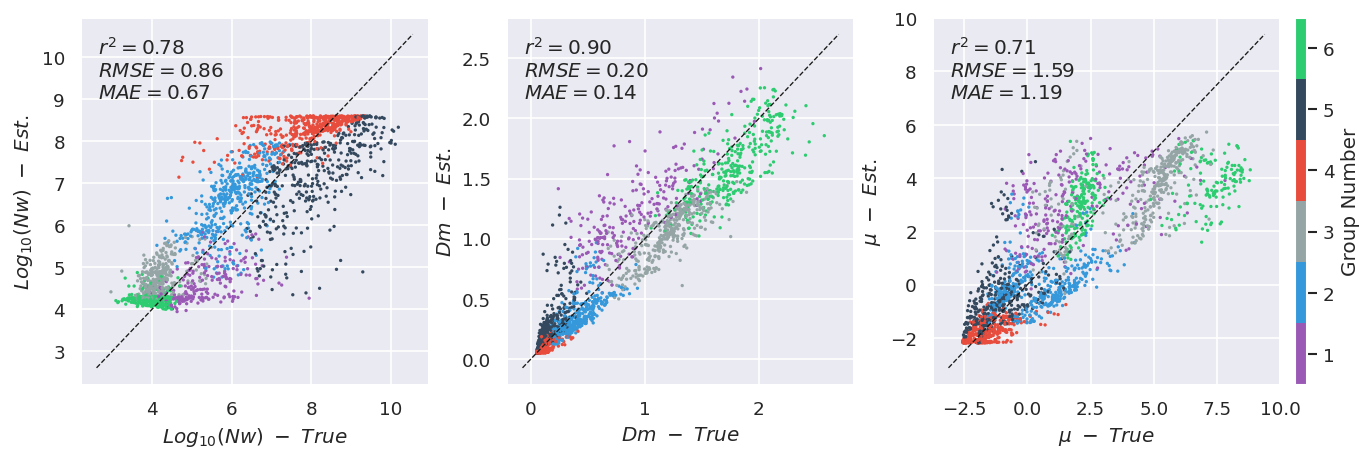

In [33]:
# 'log10_nw', 'dm', 'mu'
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(13, 4))
ax.scatter(y_test_unscaled[:, 0], yhat[:, 0], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax.set_xlabel(r"$Log_{10}(Nw) \ - \ True $")
ax.set_ylabel(r"$Log_{10}(Nw) \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 0], yhat[:, 0])

textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax1.scatter(y_test_unscaled[:, 1], yhat[:, 1], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax1.set_xlabel(r"$Dm \ - \ True $")
ax1.set_ylabel(r"$Dm \ - \ Est. $")
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 1], yhat[:, 1])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top')

sc1 = ax2.scatter(y_test_unscaled[:, 2], yhat[:, 2], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax2.set_xlabel(r"$\mu  \ - \ True $")
ax2.set_ylabel(r"$\mu \ - \ Est. $")
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 2], yhat[:, 2])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top')
x = np.linspace(*ax2.get_xlim())
ax2.plot(x, x, c='k', ls='--', lw=0.8)
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=[ax, ax1, ax2], aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))

In [34]:
del scaler_x, scaler_y

# NN using balanced data

In [35]:
lower, greater = np.bincount(df['dm_class'])
total = greater + lower
print('Examples:\n    Total: {}\n    greater: {} ({:.2f}% of total)\n'.format(
    total, greater, 100 * greater / total))

Examples:
    Total: 8710
    greater: 2807 (32.23% of total)



In [36]:
X, Y = df[['dbz_t_ku', 'dfr', 'log10_nw', 'dm', 'new_mu']].values, df[['dm_class', 'r', 'kmeans_6', 'time']].values

In [37]:
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X)
scaler_y = StandardScaler()
Y_scaled = scaler_y.fit_transform(X[:, 2:])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.25, random_state=20, stratify=df.kmeans_6)

In [39]:
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(X_train, y_train[:, 0].astype(int))
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test[:,0])}")

Training target statistics: Counter({0: 4426, 1: 4426})
Testing target statistics: Counter({0: 1477, 1: 701})


In [40]:
def build_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(3, activation="relu",
                                    input_shape=[X_train.shape[1]-3]))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(3))
    # optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)
    # optimizer = tf.keras.optimizers.RMSprop(0.001)
    # optimizer = tf.keras.optimizers.Adadelta(0.1)
    # optimizer = tf.keras.optimizers.AdamW(0.001)
    # optimizer = tf.keras.optimizers.SGD(0.001)
    model.compile(loss="mse",
              optimizer=optimizer,
              metrics=['mae', 'mse'])
    return model

In [41]:
model = build_model()

In [42]:
EPOCHS = 500
history = model.fit(X_res[:, :2], X_res[:, 2:],
                    validation_data=(X_res[:, :2], X_res[:, 2:]),
                    epochs=EPOCHS,
                    batch_size=32, verbose=0,
                    callbacks=[PrintDot(), early_stop])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...

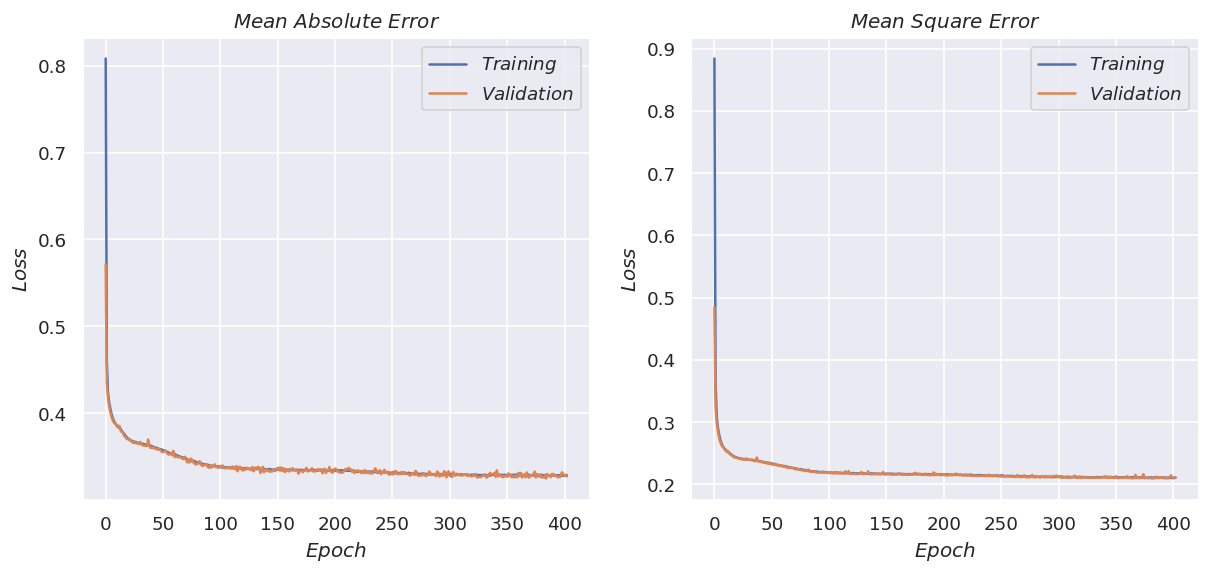

In [43]:
hist = pd.DataFrame(history.history)
plot_history(history)

In [44]:
yhat = model.predict(X_test[:, :2])
yhat = scaler_y.inverse_transform(yhat)
y_test_unscaled = scaler_y.inverse_transform(X_test[:, 2:])

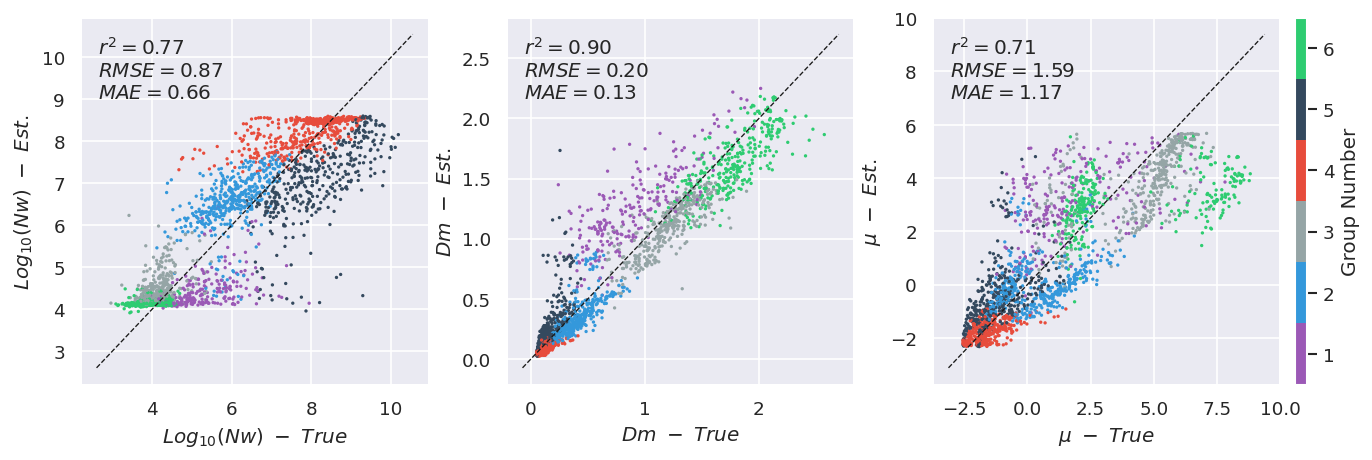

In [45]:
# 'log10_nw', 'dm', 'mu'
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(13, 4))
ax.scatter(y_test_unscaled[:, 0], yhat[:, 0], s=1, c=y_test[:, -2], cmap=my_cmap6)
ax.set_xlabel(r"$Log_{10}(Nw) \ - \ True $")
ax.set_ylabel(r"$Log_{10}(Nw) \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 0], yhat[:, 0])

textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax1.scatter(y_test_unscaled[:, 1], yhat[:, 1], s=1, c=y_test[:, -2], cmap=my_cmap6)
ax1.set_xlabel(r"$Dm \ - \ True $")
ax1.set_ylabel(r"$Dm \ - \ Est. $")
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 1], yhat[:, 1])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top')

sc1 = ax2.scatter(y_test_unscaled[:, 2], yhat[:, 2], s=1, c=y_test[:, -2], cmap=my_cmap6)
ax2.set_xlabel(r"$\mu  \ - \ True $")
ax2.set_ylabel(r"$\mu \ - \ Est. $")
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 2], yhat[:, 2])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top')
x = np.linspace(*ax2.get_xlim())
ax2.plot(x, x, c='k', ls='--', lw=0.8)
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=[ax, ax1, ax2], aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))
# plt.savefig("../results/nn_z_Dfr_retrieval.jpeg",  bbox_inches="tight")

In [46]:
nw = yhat[:, 0]
dm = yhat[:, 1]
mu_unc = yhat[:, 2]

ds_sub = xr.Dataset(
    data_vars=dict(
        nw = (["time"], 10 ** nw),
        dm = (["time"], dm),
        mu_unc = (["time"], mu_unc),
    ), 
    coords=dict(
        time=(["time"], y_test[:, -1]),
        diameter=(['diameter'], ds_lear.diameter.values)
    ),
)


In [47]:
# idx_dupp = int(np.argwhere(ds_sub.get_index("time").duplicated() == True).squeeze())
# idx_dupp

In [48]:
ds_sub = ds_sub.sel(time=~ds_sub.get_index("time").duplicated())

In [49]:
d_d = ds_lear.d_d.isel(time=0).values
d_d = np.tile(d_d, (ds_sub.nw.shape[0], 1))
d_d = xr.DataArray(data=d_d,
                   dims=['time', "diameter"])
ds_sub['d_d'] = d_d

In [50]:
ds_sub['nn_gamma_pds'] = norm_gamma(ds_lear.diameter/100, nw=ds_sub.nw, mu=ds_sub.mu_unc, dm=ds_sub.dm)

In [51]:
nn_rain = rain_retrieval(nw=ds_sub.nw, mu=ds_sub.mu_unc, dm=ds_sub.dm, d=ds_sub.diameter/1e3, d_d=ds_sub.d_d/1e3, vel_m='das')

In [52]:
# y_test = np.concatenate((y_test[:int(idx_dupp)],  y_test[int(idx_dupp)+1:]))

(0.001, 1000.0)

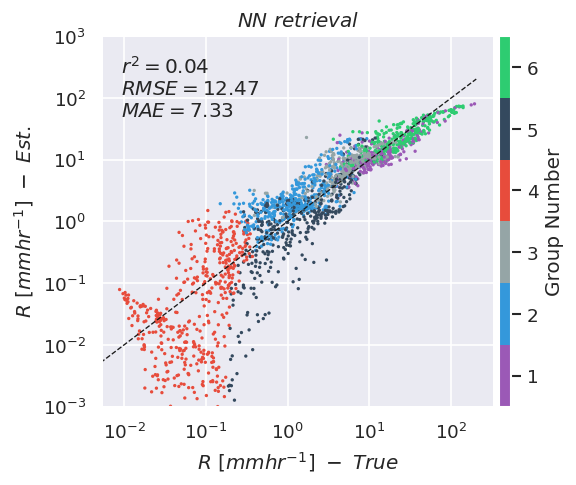

In [53]:
# 'log10_nw', 'dm', 'mu'
fig, ax = plt.subplots(figsize=(5, 4))
sc1 = ax.scatter(y_test[:, 1], nn_rain.values, s=1, c=y_test[:, -2], cmap=my_cmap6)
ax.set_xlabel(r"$R \ [mmhr^{-1}]\ - \ True $")
ax.set_ylabel(r"$R \ [mmhr^{-1}] \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test[:, 2], nn_rain.values)
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')
ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=ax, aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))
ax.set_title(r"$NN \ retrieval$")
ax.set_ylim(1e-3, 1e3)
# plt.savefig("../results/rr_nn_DFR.jpeg",  bbox_inches="tight")

In [54]:
del scaler_x, scaler_y

# Adding more parameters to the NN ('dbz_t_ku', 'dfr', 'temp',)

In [55]:
X = df[['dbz_t_ku', 'dfr', 'temp', 'log10_nw', 'dm', 'new_mu']]
Y = df[['dm_class', 'kmeans_6']]

In [56]:
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X.values)
scaler_y = StandardScaler()
Y_scaled = scaler_y.fit_transform(X[['log10_nw', 'dm', 'new_mu']].values)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y.values, test_size=0.25, random_state=20, stratify=df.kmeans_6)

In [58]:
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(X_train, y_train[:, 0])
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test[:, 0])}")

Training target statistics: Counter({0: 4426, 1: 4426})
Testing target statistics: Counter({0: 1477, 1: 701})


In [59]:
def build_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(8, activation="relu",
                                    input_shape=[X_train.shape[1]-3]))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(3))
    # optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)
    # optimizer = tf.keras.optimizers.RMSprop(0.001)
    # optimizer = tf.keras.optimizers.Adadelta(0.1)
    # optimizer = tf.keras.optimizers.AdamW(0.001)
    # optimizer = tf.keras.optimizers.SGD(0.001)
    model.compile(loss="mse",
              optimizer=optimizer,
              metrics=['mae', 'mse'])
    return model

model = build_model()

In [60]:
model = build_model()

In [61]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
EPOCHS = 500
history = model.fit(X_res[:, :3], X_res[:, 3:],
                    validation_data=(X_test[:, :3], X_test[:, 3:]),
                    epochs=EPOCHS,
                    batch_size=32, verbose=0,
                    callbacks=[PrintDot(), early_stop])


....................................................................................................
....................................................................................................
....................................................................................................
...

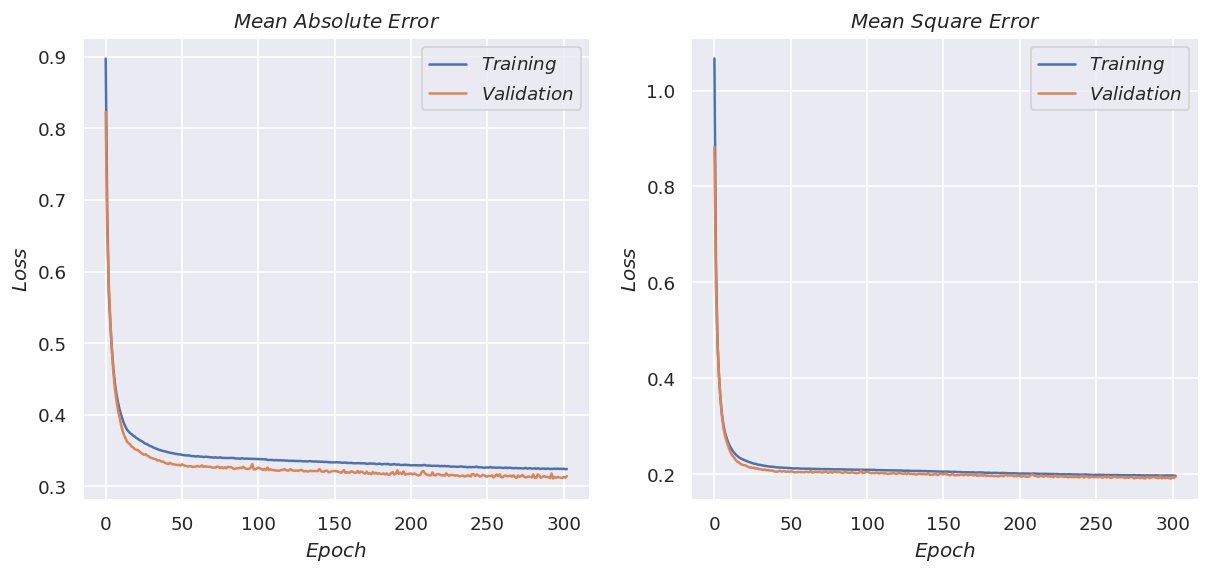

In [62]:
hist = pd.DataFrame(history.history)
plot_history(history)

yhat = model.predict(X_test[:, :3])
yhat = scaler_y.inverse_transform(yhat)
y_test_unscaled = scaler_y.inverse_transform(X_test[:, 3:])

# plot params

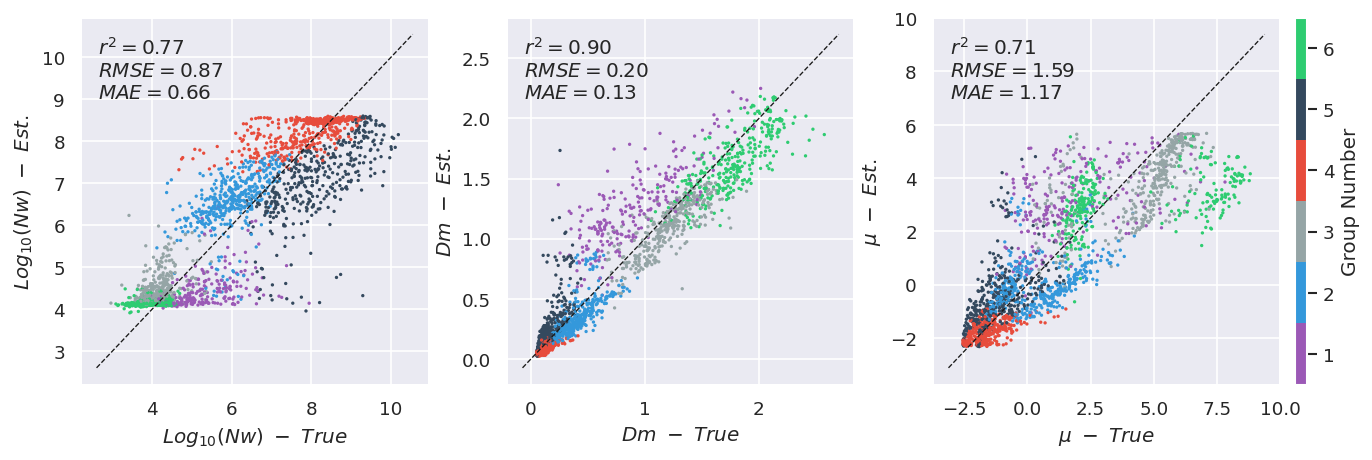

In [66]:
# 'log10_nw', 'dm', 'mu'
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(13, 4))
ax.scatter(y_test_unscaled[:, 0], yhat[:, 0], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax.set_xlabel(r"$Log_{10}(Nw) \ - \ True $")
ax.set_ylabel(r"$Log_{10}(Nw) \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 0], yhat[:, 0])

textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax1.scatter(y_test_unscaled[:, 1], yhat[:, 1], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax1.set_xlabel(r"$Dm \ - \ True $")
ax1.set_ylabel(r"$Dm \ - \ Est. $")
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 1], yhat[:, 1])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top')

sc1 = ax2.scatter(y_test_unscaled[:, 2], yhat[:, 2], s=1, c=y_test[:, -1], cmap=my_cmap6)
ax2.set_xlabel(r"$\mu  \ - \ True $")
ax2.set_ylabel(r"$\mu \ - \ Est. $")
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 2], yhat[:, 2])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top')
x = np.linspace(*ax2.get_xlim())
ax2.plot(x, x, c='k', ls='--', lw=0.8)
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=[ax, ax1, ax2], aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))

In [67]:
del scaler_x, scaler_y

NameError: name 'scaler_x' is not defined

# Adding now Height above cloud base

In [ ]:
# _df = pd.read_parquet(f"{path_data}/cloud_probes/parquet/all_data_cb.parquet").reset_index()
# df = df.reset_index()

# df['hacb'] = _df['hacb']
# X, Y = df[['dbz_t_ku', 'dfr', 'temp', 'hacb', 'log10_nw', 'dm', 'new_mu']], df[['dm_class', 'kmeans_6']]
# scaler_x = StandardScaler()
# X_scaled = scaler_x.fit_transform(X.values)
# scaler_y = StandardScaler()
# Y_scaled = scaler_y.fit_transform(X[['log10_nw', 'dm', 'new_mu']].values)

# X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y.values, test_size=0.25, random_state=20, stratify=df.kmeans_6)

In [ ]:
# over_sampler = RandomOverSampler(random_state=42)
# X_res, y_res = over_sampler.fit_resample(X_train, y_train[:,0])
# print(f"Training target statistics: {Counter(y_res)}")
# print(f"Testing target statistics: {Counter(y_test[:,0])}")

In [ ]:
# def build_model():
#     model = tf.keras.models.Sequential()
#     model.add(tf.keras.layers.Dense(8, activation="relu",
#                                     input_shape=[X_train.shape[1]-3]))
#     model.add(tf.keras.layers.Dense(8, activation="relu"))
#     model.add(tf.keras.layers.Dense(8, activation="relu"))
#     model.add(tf.keras.layers.Dense(8, activation="relu"))
#     model.add(tf.keras.layers.Dense(8, activation="relu"))
#     model.add(tf.keras.layers.Dense(8, activation="relu"))
#     model.add(tf.keras.layers.Dense(8, activation="relu"))
#     model.add(tf.keras.layers.Dense(3))
#     # optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
#     optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)
#     # optimizer = tf.keras.optimizers.RMSprop(0.001)
#     # optimizer = tf.keras.optimizers.Adadelta(0.1)
#     # optimizer = tf.keras.optimizers.AdamW(0.001)
#     # optimizer = tf.keras.optimizers.SGD(0.001)
#     model.compile(loss="mse",
#               optimizer=optimizer,
#               metrics=['mae', 'mse'])
#     return model

# model = build_model()

In [ ]:
# EPOCHS = 500
# history = model.fit(X_res[:, :4], X_res[:, 4:],
#                     validation_data=(X_test[:, :4], X_test[:, 4:]),
#                     epochs=EPOCHS,
#                     batch_size=32, verbose=0,
#                     callbacks=[PrintDot(), early_stop])

In [ ]:
# hist = pd.DataFrame(history.history)
# plot_history(history)

In [ ]:
# yhat = model.predict(X_test[:, :4])
# yhat = scaler_y.inverse_transform(yhat)
# y_test_unscaled = scaler_y.inverse_transform(X_test[:, 4:])

In [ ]:
# # 'log10_nw', 'dm', 'mu'
# fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(13, 4))
# ax.scatter(y_test_unscaled[:, 0], yhat[:, 0], s=1, c=y_test[:, -1], cmap=my_cmap6)
# ax.set_xlabel(r"$Log_{10}(Nw) \ - \ True $")
# ax.set_ylabel(r"$Log_{10}(Nw) \ - \ Est. $")
# x = np.linspace(*ax.get_xlim())
# ax.plot(x, x, c='k', ls='--', lw=0.8)
# rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 0], yhat[:, 0])

# textstr = '\n'.join((
#     r'$r^2=%.2f$' % (corr1, ),
#     r'$RMSE=%.2f$' % (rmse, ),
#     r'$MAE=%.2f$' % (mae, )))
# ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
#         verticalalignment='top')

# ax1.scatter(y_test_unscaled[:, 1], yhat[:, 1], s=1, c=y_test[:, -1], cmap=my_cmap6)
# ax1.set_xlabel(r"$Dm \ - \ True $")
# ax1.set_ylabel(r"$Dm \ - \ Est. $")
# x = np.linspace(*ax1.get_xlim())
# ax1.plot(x, x, c='k', ls='--', lw=0.8)
# rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 1], yhat[:, 1])
# textstr = '\n'.join((
#     r'$r^2=%.2f$' % (corr1, ),
#     r'$RMSE=%.2f$' % (rmse, ),
#     r'$MAE=%.2f$' % (mae, )))
# ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
#         verticalalignment='top')

# sc1 = ax2.scatter(y_test_unscaled[:, 2], yhat[:, 2], s=1, c=y_test[:, -1], cmap=my_cmap6)
# ax2.set_xlabel(r"$\mu  \ - \ True $")
# ax2.set_ylabel(r"$\mu \ - \ Est. $")
# rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 2], yhat[:, 2])
# textstr = '\n'.join((
#     r'$r^2=%.2f$' % (corr1, ),
#     r'$RMSE=%.2f$' % (rmse, ),
#     r'$MAE=%.2f$' % (mae, )))
# ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
#         verticalalignment='top')
# x = np.linspace(*ax2.get_xlim())
# ax2.plot(x, x, c='k', ls='--', lw=0.8)
# plt.tight_layout()
# cbar = fig.colorbar(sc1, ax=[ax, ax1, ax2], aspect=30, pad=0.01, label='Group Number')
# tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
# cbar.set_ticks(tick_locs)
# cbar.set_ticklabels(np.arange(1, n_c+1))

In [ ]:
# del scaler_x, scaler_y

# Testing with height

In [ ]:
# X, Y = df[['dbz_t_ku', 'dfr', 'temp', 'altitude', 'log10_nw', 'dm', 'new_mu']], df[['dm_class', 'kmeans_6']]

# scaler_x = StandardScaler()
# X_scaled = scaler_x.fit_transform(X.values)
# scaler_y = StandardScaler()
# Y_scaled = scaler_y.fit_transform(X[['log10_nw', 'dm', 'new_mu']].values)

# X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y.values, test_size=0.25, random_state=20, stratify=df.kmeans_6)

# over_sampler = RandomOverSampler(random_state=42)
# X_res, y_res = over_sampler.fit_resample(X_train, y_train[:, 0])
# print(f"Training target statistics: {Counter(y_res)}")
# print(f"Testing target statistics: {Counter(y_test[:, 0])}")

In [ ]:
# def build_model():
#     model = tf.keras.models.Sequential()
#     model.add(tf.keras.layers.Dense(8, activation="relu",
#                                     input_shape=[X_train.shape[1]-3]))
#     model.add(tf.keras.layers.Dense(8, activation="relu"))
#     model.add(tf.keras.layers.Dense(8, activation="relu"))
#     model.add(tf.keras.layers.Dense(8, activation="relu"))
#     model.add(tf.keras.layers.Dense(8, activation="relu"))
#     model.add(tf.keras.layers.Dense(8, activation="relu"))
#     model.add(tf.keras.layers.Dense(8, activation="relu"))
#     model.add(tf.keras.layers.Dense(3))
#     # optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
#     optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)
#     # optimizer = tf.keras.optimizers.RMSprop(0.001)
#     # optimizer = tf.keras.optimizers.Adadelta(0.1)
#     # optimizer = tf.keras.optimizers.AdamW(0.001)
#     # optimizer = tf.keras.optimizers.SGD(0.001)
#     model.compile(loss="mse",
#               optimizer=optimizer,
#               metrics=['mae', 'mse'])
#     return model

In [ ]:
# model = build_model()

In [ ]:
# EPOCHS = 500
# history = model.fit(X_res[:, :4], X_res[:, 4:],
#                     validation_data=(X_test[:, :4], X_test[:, 4:]),
#                     epochs=EPOCHS,
#                     batch_size=32, verbose=0,
#                     callbacks=[PrintDot(), early_stop])

In [ ]:
# hist = pd.DataFrame(history.history)
# plot_history(history)

In [ ]:
# yhat = model.predict(X_test[:, :4])
# yhat = scaler_y.inverse_transform(yhat)
# y_test_unscaled = scaler_y.inverse_transform(X_test[:, 4:])

In [ ]:
# # 'log10_nw', 'dm', 'mu'
# fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(13, 4))
# ax.scatter(y_test_unscaled[:, 0], yhat[:, 0], s=1, c=y_test[:, -1], cmap=my_cmap6)
# ax.set_xlabel(r"$Log_{10}(Nw) \ - \ True $")
# ax.set_ylabel(r"$Log_{10}(Nw) \ - \ Est. $")
# x = np.linspace(*ax.get_xlim())
# ax.plot(x, x, c='k', ls='--', lw=0.8)
# rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 0], yhat[:, 0])

# textstr = '\n'.join((
#     r'$r^2=%.2f$' % (corr1, ),
#     r'$RMSE=%.2f$' % (rmse, ),
#     r'$MAE=%.2f$' % (mae, )))
# ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
#         verticalalignment='top')

# ax1.scatter(y_test_unscaled[:, 1], yhat[:, 1], s=1, c=y_test[:, -1], cmap=my_cmap6)
# ax1.set_xlabel(r"$Dm \ - \ True $")
# ax1.set_ylabel(r"$Dm \ - \ Est. $")
# x = np.linspace(*ax1.get_xlim())
# ax1.plot(x, x, c='k', ls='--', lw=0.8)
# rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 1], yhat[:, 1])
# textstr = '\n'.join((
#     r'$r^2=%.2f$' % (corr1, ),
#     r'$RMSE=%.2f$' % (rmse, ),
#     r'$MAE=%.2f$' % (mae, )))
# ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
#         verticalalignment='top')

# sc1 = ax2.scatter(y_test_unscaled[:, 2], yhat[:, 2], s=1, c=y_test[:, -1], cmap=my_cmap6)
# ax2.set_xlabel(r"$\mu  \ - \ True $")
# ax2.set_ylabel(r"$\mu \ - \ Est. $")
# rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 2], yhat[:, 2])
# textstr = '\n'.join((
#     r'$r^2=%.2f$' % (corr1, ),
#     r'$RMSE=%.2f$' % (rmse, ),
#     r'$MAE=%.2f$' % (mae, )))
# ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
#         verticalalignment='top')
# x = np.linspace(*ax2.get_xlim())
# ax2.plot(x, x, c='k', ls='--', lw=0.8)
# plt.tight_layout()
# cbar = fig.colorbar(sc1, ax=[ax, ax1, ax2], aspect=30, pad=0.01, label='Group Number')
# tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
# cbar.set_ticks(tick_locs)
# cbar.set_ticklabels(np.arange(1, n_c+1))

# Adding LWC

In [ ]:
# X  = df[['dbz_t_ku', 'dfr', 'temp', 'lwc_cum', 'log10_nw', 'dm', 'new_mu']]
# Y =df[['dm_class', 'kmeans_6']]

In [ ]:
# scaler_x = StandardScaler()
# X_scaled = scaler_x.fit_transform(X.values)
# scaler_y = StandardScaler()
# Y_scaled = scaler_y.fit_transform(X[['log10_nw', 'dm', 'new_mu']].values)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y.values, test_size=0.25, random_state=20, stratify=df.kmeans_6)
# X_train.shape

In [ ]:
# over_sampler = RandomOverSampler(random_state=42)
# X_res, y_res = over_sampler.fit_resample(X_train, y_train[:, 0])
# print(f"Training target statistics: {Counter(y_res)}")
# print(f"Testing target statistics: {Counter(y_test[:, 0])}")

In [ ]:
# def build_model():
#     model = tf.keras.models.Sequential()
#     model.add(tf.keras.layers.Dense(8, activation="relu",
#                                     input_shape=[X_train.shape[1]-3]))
#     model.add(tf.keras.layers.Dense(8, activation="relu"))
#     model.add(tf.keras.layers.Dense(8, activation="relu"))
#     model.add(tf.keras.layers.Dense(8, activation="relu"))
#     model.add(tf.keras.layers.Dense(8, activation="relu"))
#     model.add(tf.keras.layers.Dense(8, activation="relu"))
#     model.add(tf.keras.layers.Dense(8, activation="relu"))
#     model.add(tf.keras.layers.Dense(3))
#     # optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
#     optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)
#     # optimizer = tf.keras.optimizers.RMSprop(0.001)
#     # optimizer = tf.keras.optimizers.Adadelta(0.1)
#     # optimizer = tf.keras.optimizers.AdamW(0.001)
#     # optimizer = tf.keras.optimizers.SGD(0.001)
#     model.compile(loss="mse",
#               optimizer=optimizer,
#               metrics=['mae', 'mse'])
#     return model

# model = build_model()

In [ ]:
# EPOCHS = 500
# history = model.fit(X_res[:, :4], X_res[:, 4:],
#                     validation_data=(X_test[:, :4], X_test[:, 4:]),
#                     epochs=EPOCHS,
#                     batch_size=32, verbose=0,
#                     callbacks=[PrintDot(), early_stop])

In [ ]:
# hist = pd.DataFrame(history.history)
# plot_history(history)

In [ ]:
# yhat = model.predict(X_test[:, :4])
# yhat = scaler_y.inverse_transform(yhat)
# y_test_unscaled = scaler_y.inverse_transform(X_test[:, 4:])

In [ ]:
# # 'log10_nw', 'dm', 'mu'
# fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(13, 4))
# ax.scatter(y_test_unscaled[:, 0], yhat[:, 0], s=1, c=y_test[:, -1], cmap=my_cmap6)
# ax.set_xlabel(r"$Log_{10}(Nw) \ - \ True $")
# ax.set_ylabel(r"$Log_{10}(Nw) \ - \ Est. $")
# x = np.linspace(*ax.get_xlim())
# ax.plot(x, x, c='k', ls='--', lw=0.8)
# rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 0], yhat[:, 0])

# textstr = '\n'.join((
#     r'$r^2=%.2f$' % (corr1, ),
#     r'$RMSE=%.2f$' % (rmse, ),
#     r'$MAE=%.2f$' % (mae, )))
# ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
#         verticalalignment='top')

# ax1.scatter(y_test_unscaled[:, 1], yhat[:, 1], s=1, c=y_test[:, -1], cmap=my_cmap6)
# ax1.set_xlabel(r"$Dm \ - \ True $")
# ax1.set_ylabel(r"$Dm \ - \ Est. $")
# x = np.linspace(*ax1.get_xlim())
# ax1.plot(x, x, c='k', ls='--', lw=0.8)
# rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 1], yhat[:, 1])
# textstr = '\n'.join((
#     r'$r^2=%.2f$' % (corr1, ),
#     r'$RMSE=%.2f$' % (rmse, ),
#     r'$MAE=%.2f$' % (mae, )))
# ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
#         verticalalignment='top')

# sc1 = ax2.scatter(y_test_unscaled[:, 2], yhat[:, 2], s=1, c=y_test[:, -1], cmap=my_cmap6)
# ax2.set_xlabel(r"$\mu  \ - \ True $")
# ax2.set_ylabel(r"$\mu \ - \ Est. $")
# rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 2], yhat[:, 2])
# textstr = '\n'.join((
#     r'$r^2=%.2f$' % (corr1, ),
#     r'$RMSE=%.2f$' % (rmse, ),
#     r'$MAE=%.2f$' % (mae, )))
# ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
#         verticalalignment='top')
# x = np.linspace(*ax2.get_xlim())
# ax2.plot(x, x, c='k', ls='--', lw=0.8)
# plt.tight_layout()
# cbar = fig.colorbar(sc1, ax=[ax, ax1, ax2], aspect=30, pad=0.01, label='Group Number')
# tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
# cbar.set_ticks(tick_locs)
# cbar.set_ticklabels(np.arange(1, n_c+1))

In [ ]:
# del scaler_x, scaler_y

# Adding attenuation (Ka) instead of lwc

## NN

In [103]:
X = df[['dbz_t_ku', 'dfr', 'temp', 'Att_ka', 'log10_nw', 'dm', 'new_mu']]
Y = df[['dm_class', 'r', 'kmeans_6', 'time']]

In [104]:
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X.values)
scaler_y = StandardScaler()
Y_scaled = scaler_y.fit_transform(X[['log10_nw', 'dm', 'new_mu']].values)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y.values, test_size=0.25, random_state=40, stratify=df.kmeans_6)
X_train.shape

(6532, 7)

In [106]:
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(X_train, y_train[:, 0].astype(float))
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test[:, 0])}")

Training target statistics: Counter({0.0: 4427, 1.0: 4427})
Testing target statistics: Counter({0: 1476, 1: 702})


In [107]:
def build_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(8, activation="relu",
                                    input_shape=[X_train.shape[1]-3]))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(3))
    # optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)
    # optimizer = tf.keras.optimizers.RMSprop(0.001)
    # optimizer = tf.keras.optimizers.Adadelta(0.1)
    # optimizer = tf.keras.optimizers.AdamW(0.001)
    # optimizer = tf.keras.optimizers.SGD(0.001)
    model.compile(loss="mse",
              optimizer=optimizer,
              metrics=['mae', 'mse'])
    return model

model = build_model()

In [108]:
EPOCHS = 500
history = model.fit(X_res[:, :4], X_res[:, 4:],
                    validation_data=(X_test[:, :4], X_test[:, 4:]),
                    epochs=EPOCHS,
                    batch_size=32, verbose=0,
                    callbacks=[PrintDot(), early_stop])


....................................................................................................
....................................................................................................
....................................................................................................
...........................................................................

In [120]:
path_model = f"{path_data}/cloud_probes/mode"
model.save(f"{path_model}/nn_zku_Dfr_temp_ka.h5")

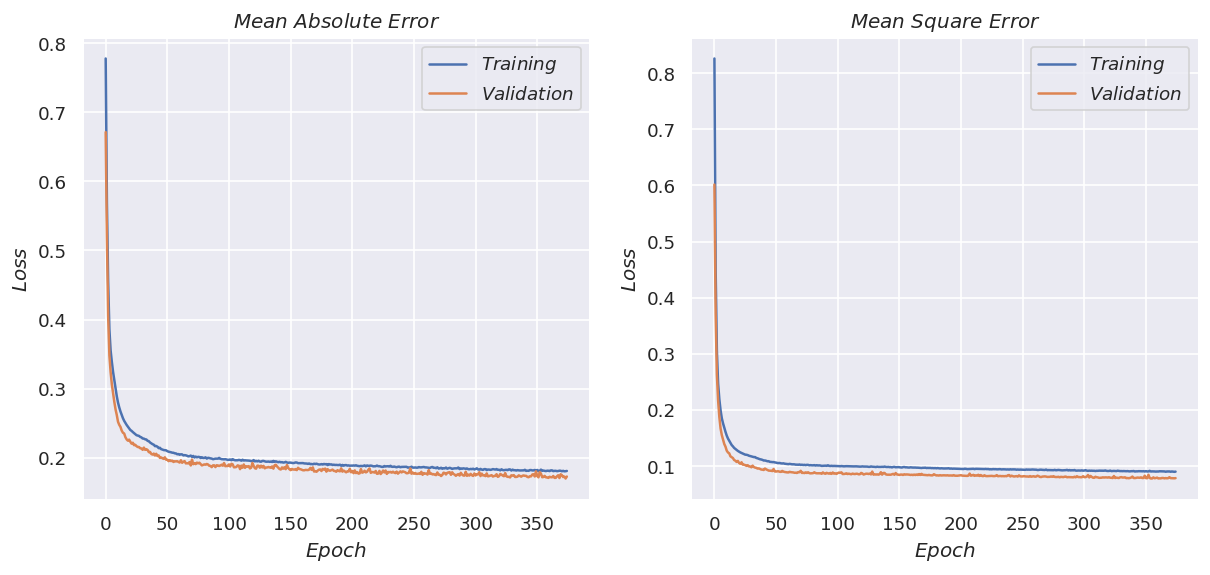

In [110]:
hist = pd.DataFrame(history.history)
plot_history(history)

In [111]:
yhat = model.predict(X_test[:, :4])
yhat = scaler_y.inverse_transform(yhat)
y_test_unscaled = scaler_y.inverse_transform(X_test[:, 4:])

## plot params

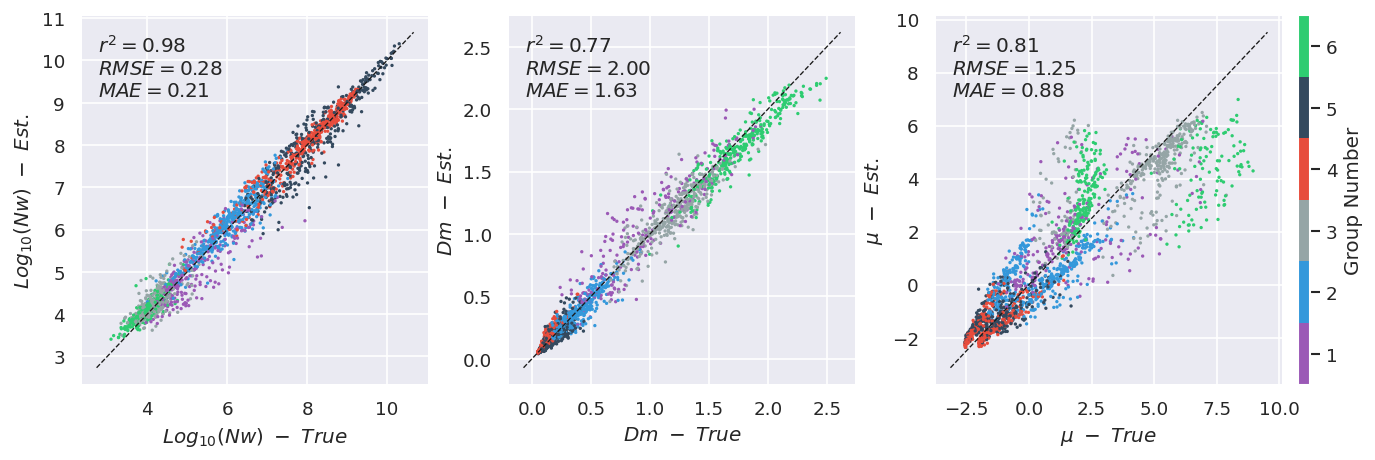

In [112]:
# 'log10_nw', 'dm', 'mu'
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(13, 4))
ax.scatter(y_test_unscaled[:, 0], yhat[:, 0], s=1, c=y_test[:, -2], cmap=my_cmap6)
ax.set_xlabel(r"$Log_{10}(Nw) \ - \ True $")
ax.set_ylabel(r"$Log_{10}(Nw) \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 0], yhat[:, 0])

textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax1.scatter(y_test_unscaled[:, 1], yhat[:, 1], s=1, c=y_test[:, -2], cmap=my_cmap6)
ax1.set_xlabel(r"$Dm \ - \ True $")
ax1.set_ylabel(r"$Dm \ - \ Est. $")
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 1], yhat[:, 2])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top')

sc1 = ax2.scatter(y_test_unscaled[:, 2], yhat[:, 2], s=1, c=y_test[:, -2], cmap=my_cmap6)
ax2.set_xlabel(r"$\mu  \ - \ True $")
ax2.set_ylabel(r"$\mu \ - \ Est. $")
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 2], yhat[:, 2])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top')
x = np.linspace(*ax2.get_xlim())
ax2.plot(x, x, c='k', ls='--', lw=0.8)
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=[ax, ax1, ax2], aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))
plt.savefig("../results/nn_ka.jpeg",  bbox_inches="tight")

## rr

In [113]:
nw = yhat[:, 0]
dm = yhat[:, 1]
mu_unc = yhat[:, 2]

ds_sub = xr.Dataset(
    data_vars=dict(
        nw = (["time"], 10 ** nw),
        dm = (["time"], dm),
        mu_unc = (["time"], mu_unc),
    ), 
    coords=dict(
        time=(["time"], y_test[:, -1]),
        diameter=(['diameter'], ds_lear.diameter.values)
    ),
)

d_d = ds_lear.d_d.isel(time=0).values
d_d = np.tile(d_d, (ds_sub.nw.shape[0], 1))
d_d = xr.DataArray(data=d_d,
                   dims=['time', "diameter"])
ds_sub['d_d'] = d_d

ds_sub['nn_gamma_pds'] = norm_gamma(ds_lear.diameter/100, nw=ds_sub.nw, mu=ds_sub.mu_unc, dm=ds_sub.dm)

nn_rain = rain_retrieval(nw=ds_sub.nw, mu=ds_sub.mu_unc, dm=ds_sub.dm, d=ds_sub.diameter/1e3, d_d=ds_sub.d_d/1e3, vel_m='das')

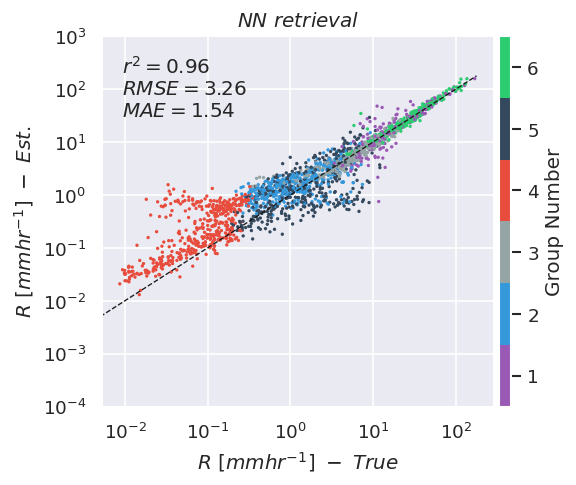

In [114]:
# 'log10_nw', 'dm', 'mu'
fig, ax = plt.subplots(figsize=(5, 4))
sc1 = ax.scatter(y_test[:, 1], nn_rain.values, s=1, c=y_test[:, -2], cmap=my_cmap6)
ax.set_xlabel(r"$R \ [mmhr^{-1}]\ - \ True $")
ax.set_ylabel(r"$R \ [mmhr^{-1}] \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test[:, 1], nn_rain.values)
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')
ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=ax, aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))
ax.set_title(r"$NN \ retrieval$")
ax.set_ylim(1e-4, 1e3)
plt.savefig("../results/rr_ka.jpeg",  bbox_inches="tight")

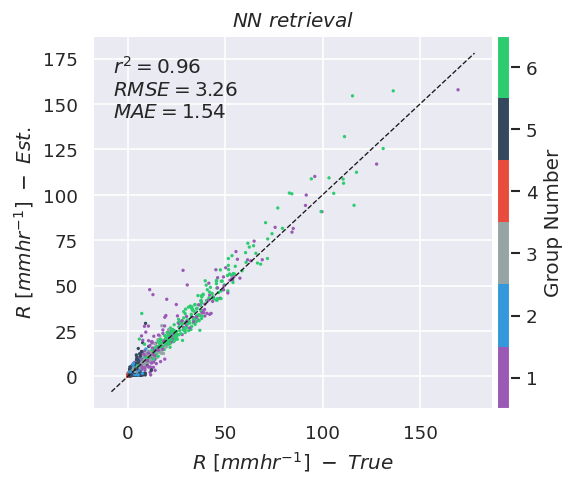

In [119]:
# 'log10_nw', 'dm', 'mu'
fig, ax = plt.subplots(figsize=(5, 4))
sc1 = ax.scatter(y_test[:, 1], nn_rain.values, s=1, c=y_test[:, -2], cmap=my_cmap6)
ax.set_xlabel(r"$R \ [mmhr^{-1}]\ - \ True $")
ax.set_ylabel(r"$R \ [mmhr^{-1}] \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test[:, 1], nn_rain.values)
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')
# ax.set_xscale('log')
# ax.set_yscale('log')
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=ax, aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))
ax.set_title(r"$NN \ retrieval$")
# ax.set_ylim(1e-4, 1e3)
plt.savefig("../results/rr_ka_linear.jpeg",  bbox_inches="tight")

# Now using Attenuation at Ku

In [121]:
X = df[['dbz_t_ku', 'dfr', 'temp', 'Att_ku', 'log10_nw', 'dm', 'new_mu']] 
Y = df[['dm_class', 'r', 'kmeans_6', 'time']]

In [122]:
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X.values)
scaler_y = StandardScaler()
Y_scaled = scaler_y.fit_transform(X[['log10_nw', 'dm', 'new_mu']].values)

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y.values, test_size=0.25, random_state=40, stratify=df.kmeans_6)
X_train.shape

(6532, 7)

In [125]:
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(X_train, y_train[:, 0].astype(float))
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test[:, 0])}")

Training target statistics: Counter({0.0: 4427, 1.0: 4427})
Testing target statistics: Counter({0: 1476, 1: 702})


In [126]:
def build_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(8, activation="relu",
                                    input_shape=[X_train.shape[1]-3]))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(3))
    # optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)
    # optimizer = tf.keras.optimizers.RMSprop(0.001)
    # optimizer = tf.keras.optimizers.Adadelta(0.1)
    # optimizer = tf.keras.optimizers.AdamW(0.001)
    # optimizer = tf.keras.optimizers.SGD(0.001)
    model.compile(loss="mse",
              optimizer=optimizer,
              metrics=['mae', 'mse'])
    return model

model = build_model()

In [127]:
EPOCHS = 500
history = model.fit(X_res[:, :4], X_res[:, 4:],
                    validation_data=(X_test[:, :4], X_test[:, 4:]),
                    epochs=EPOCHS,
                    batch_size=32, verbose=0,
                    callbacks=[PrintDot(), early_stop])


....................................................................................................
....................................................................................................
.............................................................................................

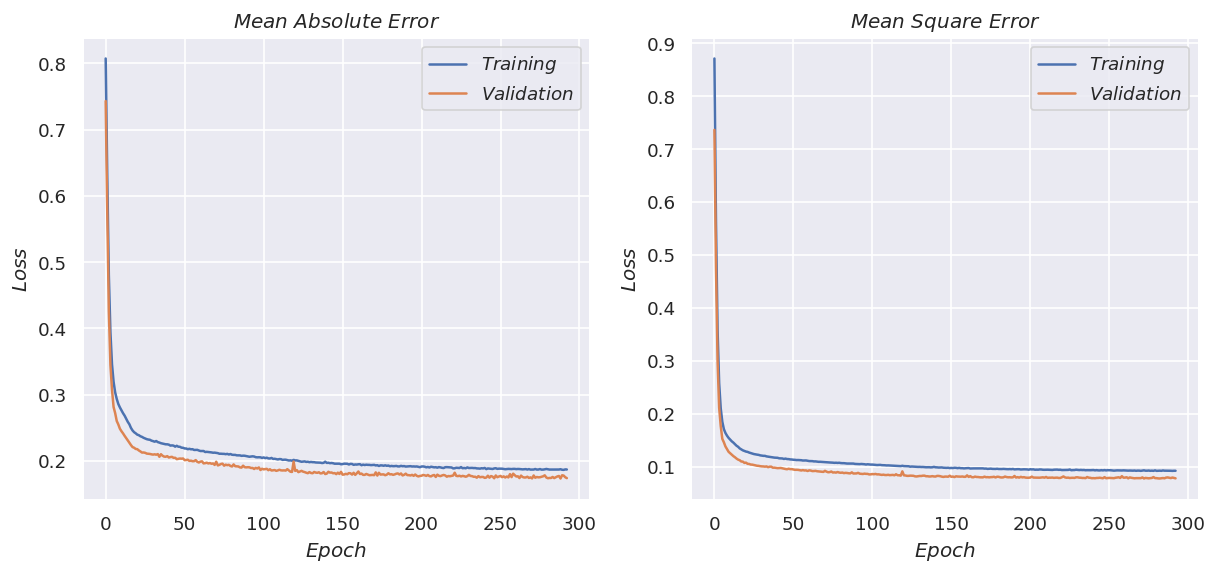

In [128]:
hist = pd.DataFrame(history.history)
plot_history(history)

In [129]:
yhat = model.predict(X_test[:, :4])
yhat = scaler_y.inverse_transform(yhat)
y_test_unscaled = scaler_y.inverse_transform(X_test[:, 4:])

# Plot params

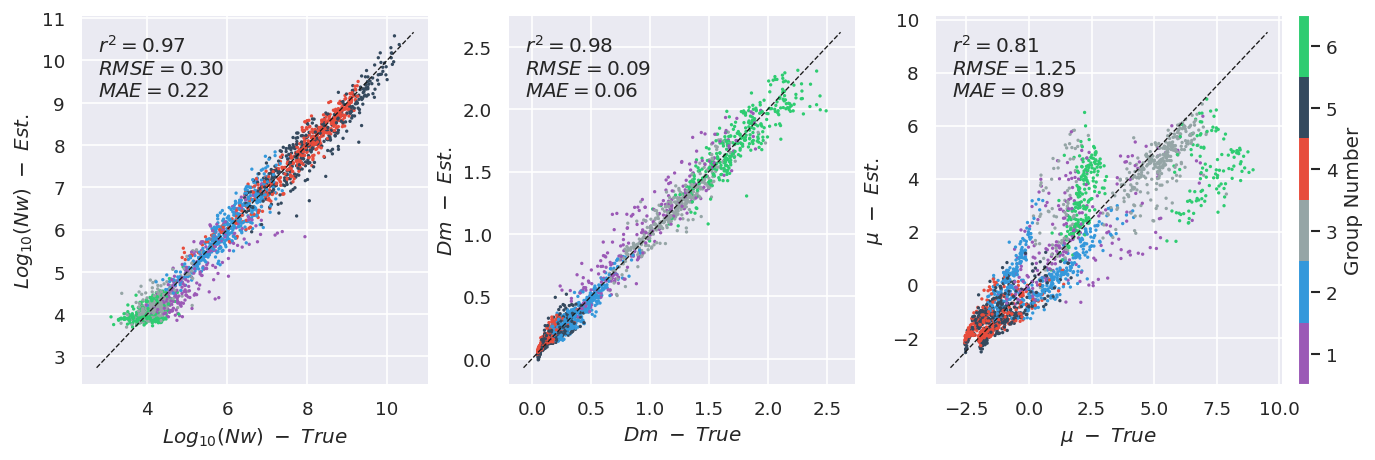

In [130]:
# 'log10_nw', 'dm', 'mu'
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(13, 4))
ax.scatter(y_test_unscaled[:, 0], yhat[:, 0], s=1, c=y_test[:, -2], cmap=my_cmap6)
ax.set_xlabel(r"$Log_{10}(Nw) \ - \ True $")
ax.set_ylabel(r"$Log_{10}(Nw) \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 0], yhat[:, 0])

textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax1.scatter(y_test_unscaled[:, 1], yhat[:, 1], s=1, c=y_test[:, -2], cmap=my_cmap6)
ax1.set_xlabel(r"$Dm \ - \ True $")
ax1.set_ylabel(r"$Dm \ - \ Est. $")
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 1], yhat[:, 1])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top')

sc1 = ax2.scatter(y_test_unscaled[:, 2], yhat[:, 2], s=1, c=y_test[:, -2], cmap=my_cmap6)
ax2.set_xlabel(r"$\mu  \ - \ True $")
ax2.set_ylabel(r"$\mu \ - \ Est. $")
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 2], yhat[:, 2])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top')
x = np.linspace(*ax2.get_xlim())
ax2.plot(x, x, c='k', ls='--', lw=0.8)
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=[ax, ax1, ax2], aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))
plt.savefig("../results/nn_params_only_ku.jpeg", bbox_inches="tight")

In [131]:
nw = yhat[:, 0]
dm = yhat[:, 1]
mu_unc = yhat[:, 2]

ds_sub = xr.Dataset(
    data_vars=dict(
        nw = (["time"], 10 ** nw),
        dm = (["time"], dm),
        mu_unc = (["time"], mu_unc),
    ), 
    coords=dict(
        time=(["time"], y_test[:, -1]),
        diameter=(['diameter'], ds_lear.diameter.values)
    ),
)

d_d = ds_lear.d_d.isel(time=0).values
d_d = np.tile(d_d, (ds_sub.nw.shape[0], 1))
d_d = xr.DataArray(data=d_d,
                   dims=['time', "diameter"])
ds_sub['d_d'] = d_d

ds_sub['nn_gamma_pds'] = norm_gamma(ds_lear.diameter/100, nw=ds_sub.nw, mu=ds_sub.mu_unc, dm=ds_sub.dm)

nn_rain = rain_retrieval(nw=ds_sub.nw, mu=ds_sub.mu_unc, dm=ds_sub.dm, d=ds_sub.diameter/1e3, d_d=ds_sub.d_d/1e3, vel_m='das')

/data/keeling/a/alfonso8/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/xarray/core/computation.py:771: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)
/data/keeling/a/alfonso8/miniconda3/envs/tf-gpu/lib/python3.9/site-packages/xarray/core/computation.py:771: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)


(0.0001, 1000.0)

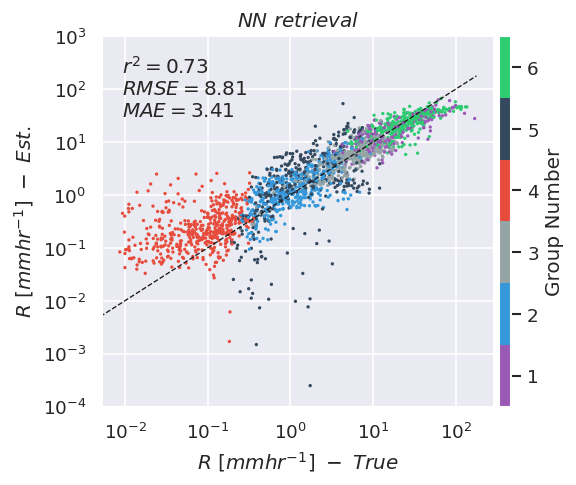

In [132]:
# 'log10_nw', 'dm', 'mu'
fig, ax = plt.subplots(figsize=(5, 4))
sc1 = ax.scatter(y_test[:, 1], nn_rain.values, s=1, c=y_test[:, -2], cmap=my_cmap6)
ax.set_xlabel(r"$R \ [mmhr^{-1}]\ - \ True $")
ax.set_ylabel(r"$R \ [mmhr^{-1}] \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test[:, 1], nn_rain.values)
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')
ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=ax, aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))
ax.set_title(r"$NN \ retrieval$")
ax.set_ylim(1e-4, 1e3)

In [133]:
del scaler_x, scaler_y

# NN using DFR, Z_ku, Temp, Att_ku, and Att_ka

In [137]:
X= df[['dbz_t_ku', 'dfr', 'temp', "Att_ku", 'Att_ka', 'log10_nw', 'dm', 'new_mu']]
Y = df[['dm_class', 'kmeans_6', 'r', 'r_dm_gm_mu_3', 'r_gpm_operational', 'r_true_nw_mu_dm', 'time', 'dm_rt_dfr_nd_mu_3', 'log10nw_dm_gm_mu_3']]

In [138]:
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X.values)
scaler_y = StandardScaler()
Y_scaled = scaler_y.fit_transform(X[['log10_nw', 'dm', 'new_mu']].values)

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y.values, test_size=0.25, random_state=40, stratify=df.kmeans_6)
X_train.shape

(6532, 8)

In [143]:
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(X_train, y_train[:, 0].astype(float))
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test[:, 0])}")

Training target statistics: Counter({0.0: 4427, 1.0: 4427})
Testing target statistics: Counter({0: 1476, 1: 702})


In [144]:
def build_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(3, activation="relu",
                                    input_shape=[X_train.shape[1]-3]))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(3))
    # optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)
    # optimizer = tf.keras.optimizers.RMSprop(0.001)
    # optimizer = tf.keras.optimizers.Adadelta(0.1)
    # optimizer = tf.keras.optimizers.AdamW(0.001)
    # optimizer = tf.keras.optimizers.SGD(0.001)
    model.compile(loss="mse",
              optimizer=optimizer,
              metrics=['mae', 'mse'])
    return model

model = build_model()

In [145]:
EPOCHS = 1500
history = model.fit(X_res[:, :5], X_res[:, 5:],
                    validation_data=(X_test[:, :5], X_test[:, 5:]),
                    epochs=EPOCHS,
                    batch_size=32, verbose=0,
                    callbacks=[PrintDot(), early_stop])


....................................................................................................
....................................................................................................
.............

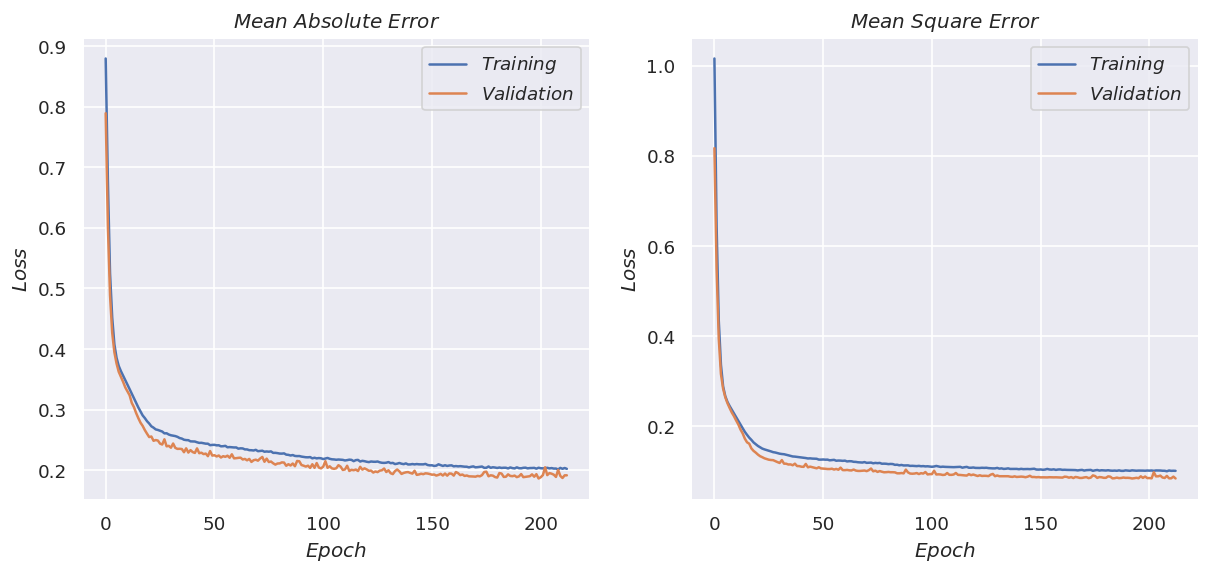

In [146]:
hist = pd.DataFrame(history.history)
plot_history(history)

In [147]:
yhat = model.predict(X_test[:, :5])
yhat = scaler_y.inverse_transform(yhat)
y_test_unscaled = scaler_y.inverse_transform(X_test[:, 5:])

# plot params

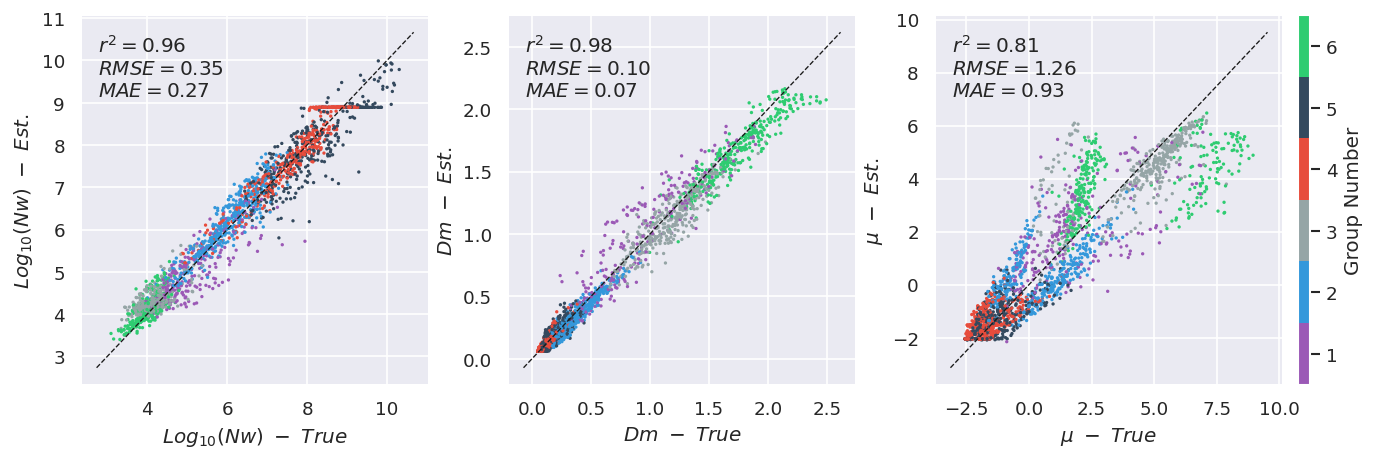

In [148]:
# 'log10_nw', 'dm', 'mu'
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(13, 4))
ax.scatter(y_test_unscaled[:, 0], yhat[:, 0], s=1, c=y_test[:, 1], cmap=my_cmap6)
ax.set_xlabel(r"$Log_{10}(Nw) \ - \ True $")
ax.set_ylabel(r"$Log_{10}(Nw) \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 0], yhat[:, 0])

textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax1.scatter(y_test_unscaled[:, 1], yhat[:, 1], s=1, c=y_test[:, 1], cmap=my_cmap6)
ax1.set_xlabel(r"$Dm \ - \ True $")
ax1.set_ylabel(r"$Dm \ - \ Est. $")
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 1], yhat[:, 1])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top')

sc1 = ax2.scatter(y_test_unscaled[:, 2], yhat[:, 2], s=1, c=y_test[:, 1], cmap=my_cmap6)
ax2.set_xlabel(r"$\mu  \ - \ True $")
ax2.set_ylabel(r"$\mu \ - \ Est. $")
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 2], yhat[:, 2])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top')
x = np.linspace(*ax2.get_xlim())
ax2.plot(x, x, c='k', ls='--', lw=0.8)
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=[ax, ax1, ax2], aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))

# Rainfall comparison

In [149]:
nw = yhat[:, 0]
dm = yhat[:, 1]
mu_unc = yhat[:, 2]

ds_sub = xr.Dataset(
    data_vars=dict(
        nw = (["time"], 10 ** nw),
        dm = (["time"], dm),
        mu_unc = (["time"], mu_unc),
    ), 
    coords=dict(
        time=(["time"], y_test[:, -1]),
        diameter=(['diameter'], ds_lear.diameter.values)
    ),
)

d_d = ds_lear.d_d.isel(time=0).values
d_d = np.tile(d_d, (ds_sub.nw.shape[0], 1))
d_d = xr.DataArray(data=d_d,
                   dims=['time', "diameter"])
ds_sub['d_d'] = d_d

ds_sub['nn_gamma_pds'] = norm_gamma(ds_lear.diameter/100, nw=ds_sub.nw, mu=ds_sub.mu_unc, dm=ds_sub.dm)

nn_rain = rain_retrieval(nw=ds_sub.nw, mu=ds_sub.mu_unc, dm=ds_sub.dm, d=ds_sub.diameter/1e3, d_d=ds_sub.d_d/1e3, vel_m='das')

(0.0001, 1000.0)

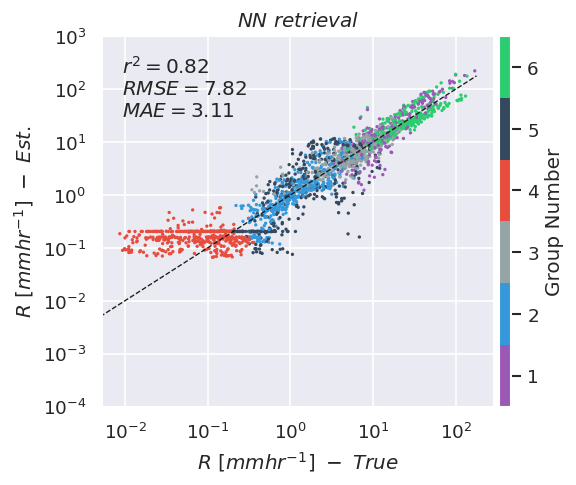

In [150]:
# 'log10_nw', 'dm', 'mu'
fig, ax = plt.subplots(figsize=(5, 4))
sc1 = ax.scatter(y_test[:, 2], nn_rain.values, s=1, c=y_test[:, 1], cmap=my_cmap6)
ax.set_xlabel(r"$R \ [mmhr^{-1}]\ - \ True $")
ax.set_ylabel(r"$R \ [mmhr^{-1}] \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test[:, 2], nn_rain.values)
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')
ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=ax, aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))
ax.set_title(r"$NN \ retrieval$")
ax.set_ylim(1e-4, 1e3)

Text(0.5, 1.0, '$NN \\ retrieval$')

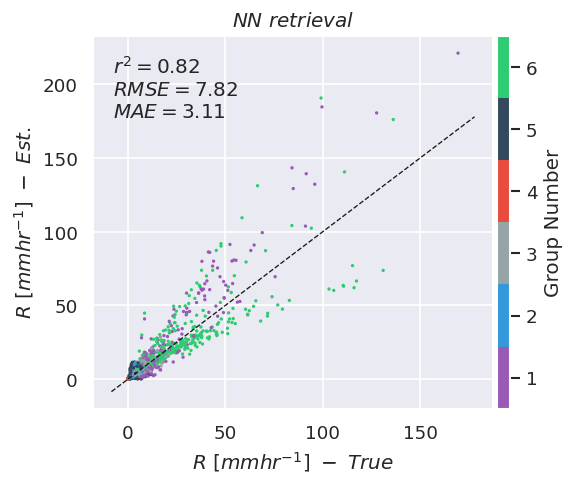

In [151]:
# 'log10_nw', 'dm', 'mu'
fig, ax = plt.subplots(figsize=(5, 4))
sc1 = ax.scatter(y_test[:, 2], nn_rain.values, s=1, c=y_test[:, 1], cmap=my_cmap6)
ax.set_xlabel(r"$R \ [mmhr^{-1}]\ - \ True $")
ax.set_ylabel(r"$R \ [mmhr^{-1}] \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test[:, 2], nn_rain.values)
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')
# ax.set_xscale('log')
# ax.set_yscale('log')
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=ax, aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))
ax.set_title(r"$NN \ retrieval$")

## RR comparison

In [152]:
xtest = scaler_x.inverse_transform(X_test)


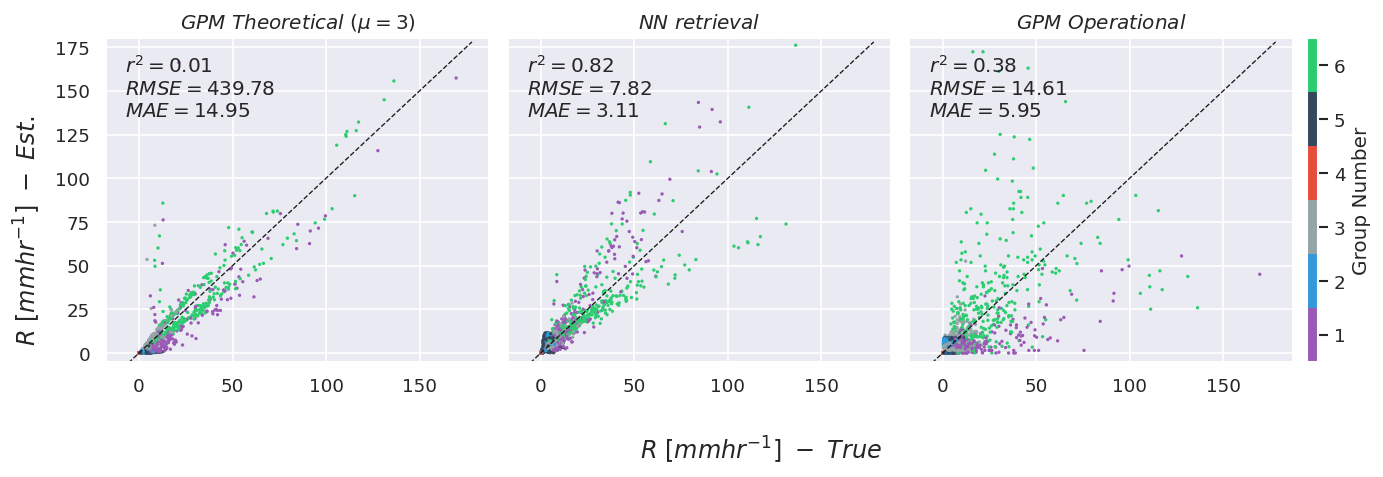

In [153]:
# 'log10_nw', 'dm', 'mu'
fig, (ax, ax2, ax1) = plt.subplots(1, 3, figsize=(13, 4), sharey=True)

sc1 = ax.scatter(y_test[:, 2], y_test[:, 3], s=1, c=y_test[:, 1], cmap=my_cmap6)
# ax.set_ylabel(r"$R \ [mmhr^{-1}] \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test[:, 2], y_test[:, 3])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_ylim(-5, 180)
ax.set_title(r"$GPM \ Theoretical \ (\mu=3)$")


sc1 = ax1.scatter(y_test[:, 2], y_test[:, 4], s=1, c=y_test[:, 1], cmap=my_cmap6)
# ax1.set_xlabel(r"$R \ [mmhr^{-1}]\ - \ True $")
# ax1.set_ylabel(r"$R \ [mmhr^{-1}] \ - \ Est. $")
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test[:, 2], y_test[:, 4])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top')
# ax1.set_xscale('log')
# ax1.set_yscale('log')
ax1.set_title(r"$GPM \ Operational$")

sc1 = ax2.scatter(y_test[:, 2], nn_rain.values, s=1, c=y_test[:, 1], cmap=my_cmap6)
# ax2.set_xlabel(r"$R \ [mmhr^{-1}]\ - \ True $")
# ax2.set_ylabel(r"$R \ [mmhr^{-1}] \ - \ Est. $")
x = np.linspace(*ax2.get_xlim())
ax2.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test[:, 2], nn_rain.values)
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top')
# ax2.set_xscale('log')
# ax2.set_yscale('log')
fig.supxlabel(r"$R \ [mmhr^{-1}]\ - \ True $")
fig.supylabel(r"$R \ [mmhr^{-1}] \ - \ Est. $")
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=[ax,ax1, ax2], aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))
ax2.set_title(r"$NN \ retrieval$")

plt.savefig("../results/rr_linear.jpeg",  bbox_inches="tight")

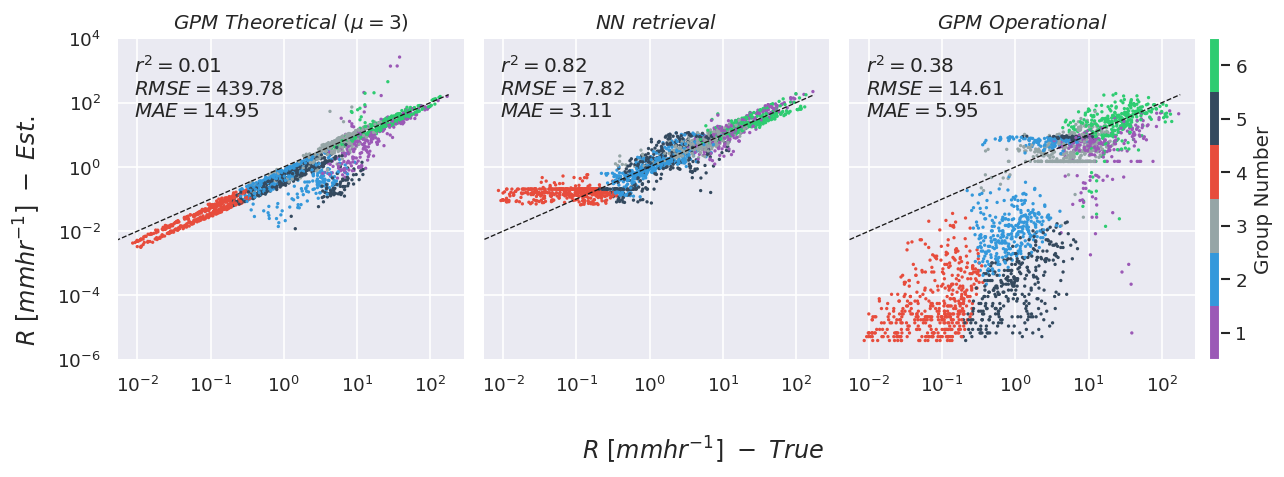

In [154]:
# 'log10_nw', 'dm', 'mu'
fig, (ax, ax2, ax1) = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

sc1 = ax.scatter(y_test[:, 2], y_test[:, 3], s=1, c=y_test[:, 1], cmap=my_cmap6)
# ax.set_ylabel(r"$R \ [mmhr^{-1}] \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
ax2.set_ylim(1e-6, 10000)
rmse, mae, corr1 = metrics_pd(y_test[:, 2], y_test[:, 3])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(-5, 180)
ax.set_title(r"$GPM \ Theoretical \ (\mu=3)$")


sc1 = ax1.scatter(y_test[:, 2], y_test[:, 4], s=1, c=y_test[:, 1], cmap=my_cmap6)
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test[:, 2], y_test[:, 4])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title(r"$GPM \ Operational$")

sc1 = ax2.scatter(y_test[:, 2], nn_rain.values, s=1, c=y_test[:, 1], cmap=my_cmap6)
x = np.linspace(*ax2.get_xlim())
ax2.plot(x, x, c='k', ls='--', lw=0.8)

rmse, mae, corr1 = metrics_pd(y_test[:, 2], nn_rain.values)
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top')
ax2.set_xscale('log')
ax2.set_yscale('log')
fig.supxlabel(r"$R \ [mmhr^{-1}]\ - \ True $")
fig.supylabel(r"$R \ [mmhr^{-1}] \ - \ Est. $")
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=[ax,ax1, ax2], aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))
ax2.set_title(r"$NN \ retrieval$")
plt.savefig("../results/rr_log.jpeg",  bbox_inches="tight")